In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/home/ruyogagp/medical_interpretability')

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from cga import cga
import pandas as pd
import neptune.new as neptune
import pytorch_lightning as pl
import torch.nn as nn
import torch
import shap_fork as shap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from captum.attr import *
from captum.metrics import *
from captum._utils.models.linear_model import SkLearnLinearRegression

In [4]:
%%capture
from riskiano.source.datamodules.simulations import *
from riskiano.source.tasks.survival import DeepSurv
from riskiano.source.modules.general import MLP
from source.wrappers import PredictRiskShapWrapper, ForwardShapWrapper

## Helper Functions

In [5]:
def load_details(name, dirpath='/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/simpson'):
    train = pd.read_csv(f'{dirpath}/{name}_train_details.csv')
    valid = pd.read_csv(f'{dirpath}/{name}_valid_details.csv')
    return train, valid

def df2csv(
        df: pd.DataFrame,
        name: str,
        output_dir: str,
):
    """
    Writes csv given a dataframe + name
    """
    train, valid = train_test_split(df, test_size=0.3)
    train.to_csv(
        f"{output_dir}/{name}_train_details.csv",
        index=False,
    )
    valid.to_csv(
        f"{output_dir}/{name}_valid_details.csv",
        index=False,
    )

    train_df = train.loc[:, ['x_orig', 'y_orig', 'time', 'event']]
    valid_df = valid.loc[:, ['x_orig', 'y_orig', 'time', 'event']]
    train_df.to_csv(
        f"{output_dir}/{name}_train.csv",
        index=False,
    )
    valid_df.to_csv(
        f"{output_dir}/{name}_valid.csv",
        index=False,
    )

# Load model

In [6]:
%%capture
run_id = 'IN-7973'
run = neptune.init(project="Cardiors/interpretability", run=run_id)
FLAGS = run['parameters'].fetch()
cpt = run['checkpoint_path'].fetch()
params = run['parameters'].fetch()
concordance = run['checkpoint_value'].fetch()
metric = run['checkpoint_metric'].fetch()
run.stop()

datamodule = CSVDatamodule
datamodule = datamodule(csv_name='simpsons_resampling',
                        dirpath='/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/simpson/',
                        batch_size=1024)
datamodule.prepare_data()
datamodule.setup()

model = DeepSurv
trained_model = model.load_from_checkpoint(cpt)
trained_model.eval()

valid_batch_size = len(datamodule.valid_ds)
valid_loader = trained_model.ext_dataloader(datamodule.valid_ds, batch_size=valid_batch_size,
                                            num_workers=8, shuffle=False, drop_last=False)
valid_batch = next(iter(valid_loader))
valid_data, *_ = trained_model.unpack_batch(valid_batch)

train_batch_size = len(datamodule.train_ds)
train_loader = trained_model.ext_dataloader(datamodule.train_ds, batch_size=train_batch_size, num_workers=8, shuffle=False, drop_last=False)
train_batch = next(iter(train_loader))
train_data, *_ = trained_model.unpack_batch(train_batch)

In [7]:
# Perturbation function
def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.002, inputs.shape)).float()
    return noise, inputs - noise

# Set baseline
zero_baseline = torch.zeros(valid_data.shape[0], valid_data.shape[1])
average = torch.mean(valid_data)
average_baseline = torch.empty(valid_data.shape[0], valid_data.shape[1]).fill_(average)

# Evaluation time
t = torch.tensor([datamodule.eval_timepoint])

def plot_attribution(out, title, normalize_colors=True):
    out = out[0] if isinstance(out, list) else out
    out = out if not isinstance(out, torch.Tensor) else out.detach()
    out_tensor = torch.Tensor(out)
    try:
        out_mean = torch.mean(out_tensor, 1).numpy()
    except:
        out_mean = torch.mean(out_tensor, 0).numpy()

    x = valid_data[:, 0]
    y = valid_data[:, 1]

    outdim0 = out[:, 0]
    outdim1 = out[:, 1]
    outdim2 = out_mean
    max_val = np.amax(np.array([abs(outdim0).max(), abs(outdim1).max(), abs(outdim2).max()]))

    fig, (ax0, ax1, ax2) =  plt.subplots(1, 3, figsize=(15,4.5))
    if normalize_colors:
        axes0 = ax0.scatter(x, y, c=outdim0,vmax=max_val, vmin=-max_val, cmap='bwr')
        axes1 = ax1.scatter(x, y, c=outdim1, vmax=max_val, vmin=-max_val,  cmap='bwr')
        axes2 = ax2.scatter(x, y, c=outdim2, vmax=max_val, vmin=-max_val,  cmap='bwr')
    else:
        axes0 = ax0.scatter(x, y, c=outdim0,  cmap='bwr')
        axes1 = ax1.scatter(x, y, c=outdim1,  cmap='bwr')
        axes2 = ax2.scatter(x, y, c=outdim2,  cmap='bwr')

    ax0.title.set_text('x attribution')
    ax1.title.set_text('y attribution')
    ax2.title.set_text('mean attribution')

    fig.subplots_adjust(right=0.8);
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7]);
    fig.colorbar(axes1, cax=cbar_ax);
    plt.title(title);
    return out_mean

<AxesSubplot:xlabel='x_do', ylabel='y_do'>

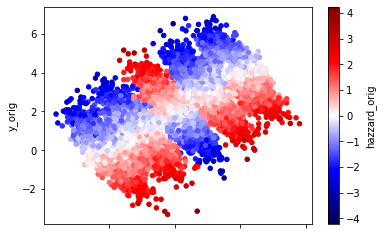

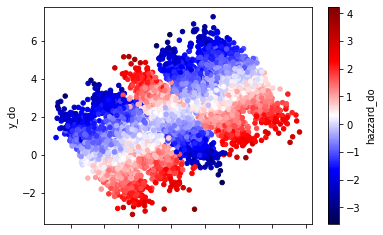

In [8]:
train_details, valid_details = load_details("simpsons_resampling")

valid_details.plot.scatter("x_orig", "y_orig", c="hazzard_orig",
                           vmax=abs(valid_details["hazzard_orig"].max()),
                           vmin=-abs(valid_details["hazzard_orig"].max()),
                           cmap="seismic", colorbar=True)
valid_details.plot.scatter("x_do", "y_do", c="hazzard_do", cmap="seismic")

## Score diff function

In [38]:
def score_diff(model, df: pd.DataFrame):
    """
    Calculates the difference between model output with original vs resampled inputs
    :param model: model to do inferences on
    :param df: dataframe with the column x/y orign and x/y do
    :return: score difference
    """
    xy_orig = df[['x_orig', 'y_orig']].rename(
        {'x_orig': 'x', 'y_orig': 'y'})
    xy_do = df[['x_do', 'y_do']].rename(
        {'x_do': 'x', 'y_do': 'y'})
    xy_orig = xy_orig.to_numpy(dtype='float32')
    xy_do = xy_do.to_numpy(dtype='float32')

    orig_vals = model(torch.from_numpy(xy_orig))
    do_vals = model(torch.from_numpy(xy_do))

    orig_vals = orig_vals if not isinstance(orig_vals, tuple) else orig_vals[0]
    do_vals = do_vals if not isinstance(do_vals, tuple) else do_vals[0]

    with torch.no_grad():
        diff = torch.sub(orig_vals, do_vals)
    return diff.detach().numpy()

def clip_outliers(xdf, ydf, attr_x, attr_y, attr_name):
    """
    Clip the outliers and computes the attribution error
    """
    # For the changed x
    outliers = np.percentile(xdf['change_slope_model'], [0.5, 99.5])
    clipped_array = np.clip(xdf.change_slope_model.to_numpy(), *outliers)
    xdf.loc[:,'change_slope_model_norm'] = clipped_array / abs(clipped_array).max()

    outliers = np.percentile(ydf['change_slope_model'], [0.5, 99.5])
    clipped_array = np.clip(ydf.change_slope_model.to_numpy(), *outliers)
    ydf.loc[:,'change_slope_model_norm_y'] = clipped_array / abs(clipped_array).max()

    attr_x = attr_x[:, 0].detach().numpy() if isinstance(attr_x, torch.Tensor) else attr_x[:, 0]
    attr_y = attr_y[:, 1].detach().numpy() if isinstance(attr_y, torch.Tensor) else attr_y[:, 1]

    outliers = np.percentile(attr_x, [0.5, 99.5])
    clipped_array = np.clip(xdf.change_slope_model.to_numpy(), *outliers)
    xdf.loc[:, f'{attr_name}_norm'] = clipped_array / abs(clipped_array).max()

    outliers = np.percentile(attr_y, [0.5, 99.5])
    clipped_array = np.clip(ydf.change_slope_model.to_numpy(), *outliers)
    ydf.loc[:, f'{attr_name}_norm_y'] = clipped_array / abs(clipped_array).max()

def run_attribution(method, input_x, input_y, baseline=None):
    """
    :param method: initiated explanation method
    :param input_x: input for dimension x
    :param input_y: input for dimension y
    :param baseline: baseline to use, currently only works with captum stuff
    :return: attribution for dimension x and dimension y
    """
    if isinstance(method, shap.KernelExplainer) :
        attr_x = method.shap_values(input_x.values)[0].astype('float32')
        attr_y = method.shap_values(input_y.values)[0].astype('float32')
    elif isinstance(method, shap.DeepExplainer):
        attr_x = method.shap_values(torch.Tensor(input_x.values), baseline).astype('float32')
        attr_y = method.shap_values(torch.Tensor(input_y.values), baseline).astype('float32')
    else:
        try:
            attr_x = method(torch.Tensor(input_x.values), baselines=baseline)
            attr_y = method(torch.Tensor(input_y.values), baselines=baseline)
        except TypeError:
            attr_x = method(torch.Tensor(input_x.values))
            attr_y = method(torch.Tensor(input_y.values))
    return attr_x, attr_y


def change_slope(df, attr_method, attr_name, baseline=None):
    """
    Calculates change slope of model with respect to attributions
    :param df: dataframe with resampled features
    :param attribution: attribution method
    :param attr_name: name of the attribution method (to be used to name the dataframe column)
    :return:
    """
    df.loc[:, 'model_diff'] = np.zeros(len(df))
    df.loc[:, 'attr_diff'] = np.zeros(len(df))

    for attr in pd.unique(df.modified_attribute):
        idx = df.modified_attribute == attr
        df.loc[idx, 'model_diff'] = score_diff(trained_model, df=df[idx])
        df.loc[idx, 'attr_diff'] = df[idx][attr + '_orig'] - df[idx][attr + '_do']

    df.loc[:, 'change_slope_model'] = df.model_diff / df.attr_diff
    xdf = df.loc[valid_details['modified_attribute'] == 'noise_x']
    ydf = df.loc[valid_details['modified_attribute'] == 'noise_y']
    input_xdf = pd.DataFrame(dict(x_orig=xdf.x_orig, y_orig=xdf.y_orig))
    input_ydf = pd.DataFrame(dict(x_orig=ydf.x_orig, y_orig=ydf.y_orig))
    # get attributions
    attr_x, attr_y = run_attribution(attr_method, input_xdf, input_ydf, baseline=baseline)

    xdf.loc[:, f'{attr_name}'] = list(attr_x.detach().numpy()) if isinstance(attr_x, torch.Tensor) else list(attr_x)
    ydf.loc[:, f'{attr_name}_y'] = list(attr_y.detach().numpy()) if isinstance(attr_y, torch.Tensor) else list(attr_y)
    clip_outliers(xdf, ydf, attr_x, attr_y, attr_name)

    xdf.loc[:, f'{attr_name}_error'] = abs(xdf.loc[:,f'{attr_name}_norm'] - xdf.loc[:,'change_slope_model_norm'])
    ydf.loc[:, f'{attr_name}_error_y'] = abs(ydf.loc[:,f'{attr_name}_norm_y'] - ydf.loc[:,'change_slope_model_norm_y'])

    # concat df & fill nans
    result = pd.concat([df, xdf.iloc[:, 20:], ydf.iloc[:, 20:]], axis=1)
    column_names = [f'{attr_name}', 'change_slope_model_norm', f'{attr_name}_norm', f'{attr_name}_error']
    for column_name in column_names:
        result.loc[result[f'{column_name}'].isnull(),f'{column_name}'] = result[f'{column_name}_y']
        del result[f'{column_name}_y']

    # plot error
    print(f'average {attr_name} x dim error =', xdf[f'{attr_name}_error'].mean())
    print(f'average {attr_name} y dim error =', ydf[f'{attr_name}_error_y'].mean())
    print(f'average {attr_name} error =', result[f'{attr_name}_error'].mean())
    result.plot.scatter('x_orig', 'y_orig', c=f'{attr_name}_error', vmax = 1.0, vmin=0.0,
                    cmap="PuBu", colorbar=True)

    return xdf, ydf, result

## Calculate Attribution Errors

In [10]:
zero_baseline = torch.zeros(*valid_data.shape)
forward_wrapper = ForwardShapWrapper(trained_model, method='FeaturePermutation')
fa = FeatureAblation(forward_wrapper)
fp = FeaturePermutation(forward_wrapper)
ixg = InputXGradient(forward_wrapper)
svs = ShapleyValueSampling(forward_wrapper)
saliency = Saliency(forward_wrapper)

### Baselines + Shap wrappers

In [12]:
zero_baseline = torch.zeros(1, valid_data.shape[1])
ones_baseline = torch.ones(1, valid_data.shape[1])
train_sampling_baseline = shap.sample(train_data, 100)
train_kmeans_baseline = shap.kmeans(train_data, 100)
mean_baseline = torch.full_like(zero_baseline, torch.mean(valid_data))

forward_wrapper_kernel = ForwardShapWrapper(trained_model, method='KernelExplainer')
forward_wrapper_deep = ForwardShapWrapper(trained_model, method='DeepExplainer')

## KernelExplainer

average KernelExplainer x dim error = 0.13821910148489125
average KernelExplainer y dim error = 0.04126364875926671
average KernelExplainer error = 0.08965249929041379


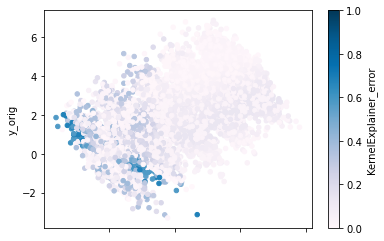

In [16]:
# zero baseline
kernel_explainer_zero = shap.KernelExplainer(forward_wrapper_kernel, zero_baseline)
train_details, valid_details = load_details("simpsons_resampling")
xdf, ydf, df = change_slope(valid_details, kernel_explainer_zero, 'KernelExplainer', baseline=zero_baseline)

average KernelExplainer_mean x dim error = 0.1418455164551783
average KernelExplainer_mean y dim error = 0.04052031108494595
average KernelExplainer_mean error = 0.09109003233180621


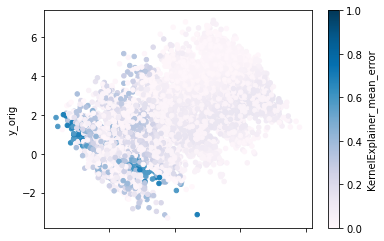

In [17]:
# mean baseline
kernel_explainer_mean = shap.KernelExplainer(forward_wrapper_kernel, mean_baseline)
train_details, valid_details = load_details('simpsons_resampling')
xdf, ydf, df = change_slope(valid_details, kernel_explainer_mean, 'KernelExplainer_mean')

average KernelExplainer_sampled x dim error = 0.16532398829980058
average KernelExplainer_sampled y dim error = 0.039030934830076094
average KernelExplainer_sampled error = 0.10206169293259108


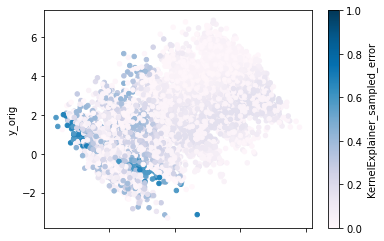

In [20]:
# sampled train loader baseline
kernel_explainer_train = shap.KernelExplainer(forward_wrapper_kernel, train_sampling_baseline)
train_details, valid_details = load_details('simpsons_resampling')
xdf, ydf, df = change_slope(valid_details, kernel_explainer_train, 'KernelExplainer_sampled')

average KernelExplainer_kmeans x dim error = 0.15993248491509549
average KernelExplainer_kmeans y dim error = 0.04606776403060485
average KernelExplainer_kmeans error = 0.10289574847870654


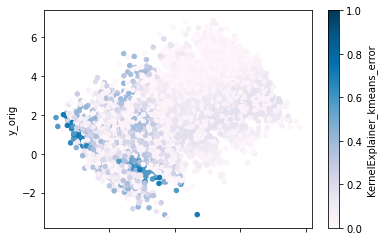

In [19]:
# kmeans clustered baseline
kernel_explainer_train = shap.KernelExplainer(forward_wrapper_kernel, train_kmeans_baseline)
train_details, valid_details = load_details('simpsons_resampling')
xdf, ydf, df = change_slope(valid_details, kernel_explainer_train, 'KernelExplainer_kmeans')

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


average DeepExplainer x dim error = 0.07080073980056273
average DeepExplainer y dim error = 0.03371898128406563
average DeepExplainer error = 0.05222586893034052


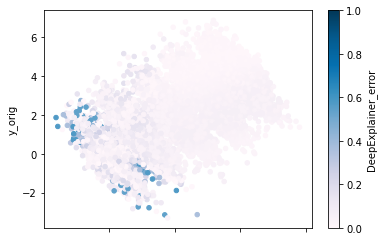

In [21]:
# zero baseline
deep_explainer_zero = shap.DeepExplainer(forward_wrapper_deep, zero_baseline)
train_details, valid_details = load_details("simpsons_resampling")
xdf, ydf, df = change_slope(valid_details, deep_explainer_zero, 'DeepExplainer', baseline=zero_baseline)

## DeepExplainer

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


average DeepExplainer_kmeans x dim error = 0.11655184507506855
average DeepExplainer_kmeans y dim error = 0.044305919415580736
average DeepExplainer_kmeans error = 0.08036265681347007


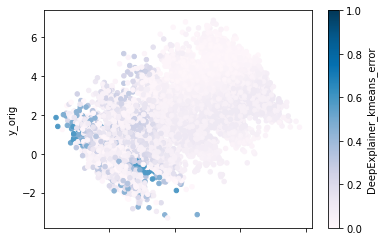

In [28]:
# baseline from train_data - this is for 100 samples
kmeans_baseline = torch.Tensor(shap.kmeans(train_data, 100).data)
deep_explainer_sampling = shap.DeepExplainer(forward_wrapper_deep, kmeans_baseline)
train_details, valid_details = load_details("simpsons_resampling")
xdf, ydf, df = change_slope(valid_details, deep_explainer_sampling, 'DeepExplainer_kmeans')

average DeepExplainer_sampling x dim error = 0.11608520289478148
average DeepExplainer_sampling y dim error = 0.044502575487608026
average DeepExplainer_sampling error = 0.08022827178273874


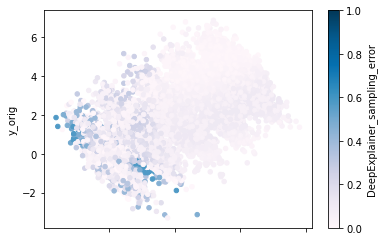

In [30]:
# train baseline (sampling) - this is for 1000 samples
sampling_baseline = shap.sample(train_data, 100)
deep_explainer_sampling = shap.DeepExplainer(forward_wrapper_deep, sampling_baseline)
train_details, valid_details = load_details("simpsons_resampling")
xdf, ydf, df = change_slope(valid_details, deep_explainer_sampling, 'DeepExplainer_sampling')

## Captum Stuff

average FeatureAblation x dim error = 0.07131532858458396
average FeatureAblation y dim error = 0.017334978492039566
average FeatureAblation error = 0.04427567155072703


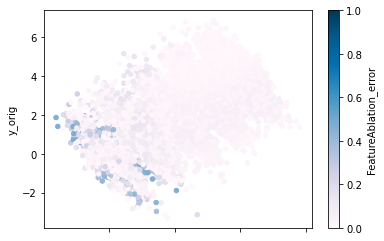

In [33]:
train_details, valid_details = load_details("simpsons_resampling")
xdf, ydf, df = change_slope(valid_details, fa.attribute, 'FeatureAblation', baseline=zero_baseline)

average FeaturePermutation x dim error = 0.029311673124958134
average FeaturePermutation y dim error = 0.0794477504725241
average FeaturePermutation error = 0.05442566986964294


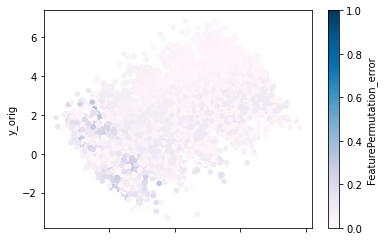

In [39]:
train_details, valid_details = load_details("simpsons_resampling")
xdf, ydf, df = change_slope(valid_details, fp.attribute, 'FeaturePermutation')

average ShapleyValueSampling x dim error = 0.13381003521141885
average ShapleyValueSampling y dim error = 0.04302158597324045
average ShapleyValueSampling error = 0.08833258784719462


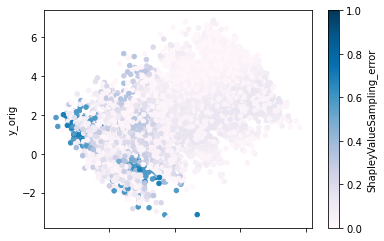

In [40]:
train_details, valid_details = load_details("simpsons_resampling")
xdf, ydf, df = change_slope(valid_details, svs.attribute, 'ShapleyValueSampling')